# Learn Embeddings using Graph Networks
> Various short tutorials on using graph network models to learn embeddings, classification and visualization

## Setup

### Installation

In [ ]:
!git clone https://github.com/shenweichen/GraphEmbedding.git
!cd GraphEmbedding && python setup.py install
%cd /content/GraphEmbedding/examples

In [ ]:
!pip install umap-learn
!pip install -q karateclub

### Imports

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from ge.classify import read_node_label, Classifier
from ge import Node2Vec, DeepWalk, LINE, SDNE

import networkx as nx
import json

import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec

import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import operator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Utils

In [ ]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('../data/wiki/wiki_labels.txt')
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)

In [ ]:
def plot_embeddings(embeddings):
    X, Y = read_node_label('../data/wiki/wiki_labels.txt')

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

## Concepts

### Random Walk

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/walk.gif'>

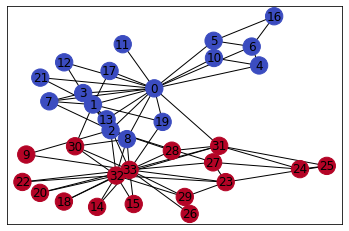

In [ ]:
G = nx.karate_club_graph()
clubs = []
for n in G.nodes:
    c = G.nodes[n]['club']
    clubs.append(1 if c == 'Officer' else 0)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm')

Random walk is a sequence of nodes, where next node is chosen randomly from the adjacent nodes. For example, let's start our random walk from node 25. From the graph above we can see that the node 25 (right-most) is connected to the nodes 24 and 31. Hence, using a coin-flip we'll determine where we go next. If we've arrived at the node 24, we can see that it's connected to the members 23, 27, and 31. Again, we need to choose randomly where to go next. This "walk" continues until we've reached the desired walk length. Let's now write a simple function to implement this in code.

In [ ]:
def random_walk(start_node, walk_length):
    walk = [start_node]  # starting node
    
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  # get all neighbours of the node
        next_node = np.random.choice(all_neighbours, 1)[0]  # randomly pick 1 neighbour
        walk.append(next_node)  # append this node to the walk
        start_node = next_node  # this random node is now your current state
    
    return walk

Steps in random walk: [6, 5, 16, 5, 10, 5, 16, 5, 0, 7, 1, 3, 2, 27, 2, 7, 3, 2, 9, 2, 1]


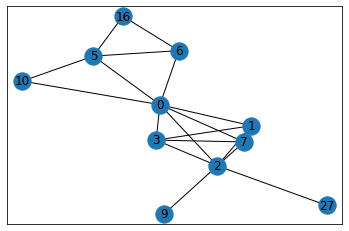

In [ ]:
walk = random_walk(6, 20)  # random walk from node 6
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

So we've generated a random walk with length of 20 starting at node 6. You can follow the steps of this walk on the graph above and see that every step is between connected nodes. By doing this walk we've got useful information about the context of the node 6. By that I mean that we now know some of the neighbours (and neighbours' neighbours) of node 6 which could be useful in classification problem for example. By repeating this random walk multiple times for all the nodes in the graph, we can get a bunch of "walk" sequences that contain useful information. The paper suggests doing around 32 walks per node with the walk length of 40. We could implement this with 2 for-loops but luckily for us, karateclub package has already implemented this for us (and it's much faster)

In [ ]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)  # you can access the walks in walker.walks 

### Skip Gram

Now the question is - how can we get meaningful embeddings using the generated random walks? Well, you've ever worked with NLP you already know the answer - use the Word2Vec algorithm. In particular, we're going to use the skip-gram model with hierarchical softmax layer. There are a lot of detailed resources about the inner workings of these algorithms, but here are my favourites - Word2Vec explained by [Rasa](https://www.youtube.com/watch?v=BWaHLmG1lak) and hierarchical softmax explained by [Chris McCormick](https://www.youtube.com/watch?v=pzyIWCelt_E).

The main idea of the skip-gram model is to predict the context of a sequence from a particular node (or word). For example, if we want to train embeddings for node 6 (example above), we'll train our model (usually a simple dense neural network) with the goal to predict the nodes that appear in it's random walks. So, the model's input will be the node 6 (one-hot-encoded), middle layer will be the actual embedding, and output will be prediction of the node's context. This is a very high-level explanation and I encourage you to watch the videos above if you feel confused.

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F337b4217-0e9d-40b2-9a4d-143afdc607a1%2FUntitled.png?table=block&id=dd314356-d9d9-4d93-9f80-3ce4acdeb0b6&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

we can use the gensim implementation of the algorithm to get the embeddings.

In [ ]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)

In [ ]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


And that's it! The embeddings are trained, so you can use them e.g. as features for your supervised model or to find clusters in your dataset. Let's now see how we can use DeepWalk on real classification taks.

## DeepWalk

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F48cf4be5-e56b-409a-8518-75113e01ab2c%2FUntitled.png?table=block&id=0ed64433-5b07-47aa-b9e5-7971f7fbe308&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

[DeepWalk](http://www.perozzi.net/publications/14_kdd_deepwalk.pdf) uses short random walks to learn representations for vertices in graphs. It is a type of graph neural network — a type of neural network that operates directly on the target graph structure. It uses a randomized path traversing technique to provide insights into localized structures within networks. It does so by utilizing these random paths as sequences, that are then used to train a Skip-Gram Language Model.

The DeepWalk process operates in 2 steps:
1. For each node, perform N “random steps” starting from that node
2. Treat each walk as a sequence of node-id strings
3. Given a list of these sequences, train a word2vec model using the Skip-Gram algorithm on these string sequences

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fb90a11f1-0793-475f-8391-f33a36532e5c%2FUntitled.png?table=block&id=2cabccb5-6261-4fbe-828e-85b5e2410c48&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

### Wiki

In [ ]:
G = nx.read_edgelist('../data/wiki/Wiki_edgelist.txt',
                      create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

model = DeepWalk(G, walk_length=10, num_walks=80, workers=1)
model.train(window_size=5, iter=3)
embeddings = model.get_embeddings()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


Learning embedding vectors...
Learning embedding vectors done!


In [ ]:
evaluate_embeddings(embeddings)

Training classifier using 80.00% nodes...
-------------------
{'micro': 0.6798336798336798, 'macro': 0.6017105026214954, 'samples': 0.6798336798336798, 'weighted': 0.6800370059532663, 'acc': 0.6798336798336798}


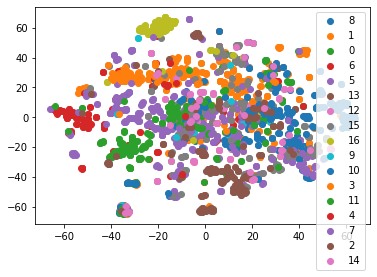

In [ ]:
plot_embeddings(embeddings)

### Karate club

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fe3791aa4-fb5a-4ce2-915c-1e4390b7b8f3%2FUntitled.png?table=block&id=1d431d4e-1c04-4212-b9d4-7a8d02161e2b&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

We are going to use famous Zachary's karate club dataset which comes with NetworkX package and karateclub's implementation of the DeepWalk algorithm. Each student in the graph belongs to 1 of the 2 karate clubs - Officer or Mr. Hi.

In [ ]:
G = nx.karate_club_graph()  # load data

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

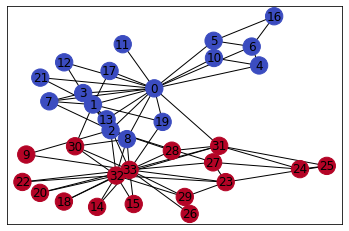

In [ ]:
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

As you can see, members of the karate clubs talk mainly to their club members. This information could be very valuable for e.g. classification or community detection tasks and we can represent it using the node embeddings.

In [ ]:
model = DeepWalk(dimensions=124, epochs=1)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


Using DeepWalk (which is a black box algorithm for now) each karate club member is now represented by a vector of size 124. These vectors should reflect the graph structure, i.e. the different clubs should be far away from each other. We can check it by reducing the 124 dimensional data into 2 dimensional data using umap-learn package and making a scatter plot.

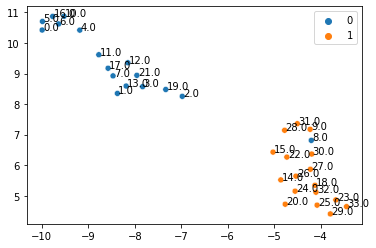

In [ ]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))

As you can see, the embeddings did very well at representing the structure of the graph. Not only the two karate clubs are clearly separated but the members which are connected to the other clubs (e.g. nodes 28, 30, 8, and 2) are sort of more in the middle. In addition, the algorithm seems to have found a sub-community in the "Officer" karate club, which just shows how useful these embeddings can be. To summarise, DeepWalk (and any other node embedding algorithm) tries to represent the nodes as vectors which capture some structural information from the graph.

### Facebook

In [ ]:
!wget http://nrvis.com/download/data/soc/fb-pages-politician.zip
!unzip fb-pages-politician

In [ ]:
edges_path = 'https://github.com/benedekrozemberczki/MUSAE/blob/master/input/edges/facebook_edges.csv?raw=true'
targets_path = 'https://github.com/benedekrozemberczki/MUSAE/blob/master/input/target/facebook_target.csv?raw=true'
features_path = 'https://github.com/benedekrozemberczki/MUSAE/blob/master/input/features/facebook.json?raw=true'

In [ ]:
features_filename = 'facebook.json'
!wget -O $features_filename $features_path

In [ ]:
edges = pd.read_csv(edges_path)
display(edges.head())

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [ ]:
targets = pd.read_csv(targets_path)
targets.index = targets.id
targets.head()

,id,facebook_id,page_name,page_type
id,,,,
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [ ]:
# Reading the json as a dict
with open(features_filename) as json_data:
    features = json.load(json_data)

With data read in, we can build a graph now and generate the embeddings

In [ ]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

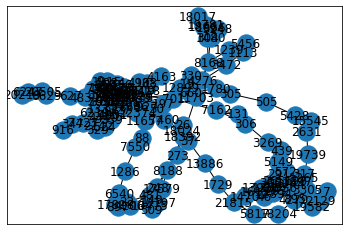

In [ ]:
# Visualise some subgraph of 150 nodes
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))[:150] #Gets all the nodes in the graph that node 7 belongs to. 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

In [ ]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

In [ ]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 workers=4,
                 seed=42)

DeepWalk model is now trained, so we can use the embeddings for classification. We can do a quick sense check of the model by looking at the nearest neighbours in the embeddings space of some of the facebook pages. For example, let's check the most similar nodes to the Facebook page of American Express (ID 22196) and the BBC's show Apprentice (ID 451)

In [ ]:
similar_to = '22196'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
22196,22196,205251616243022,American Express,company
4433,4433,309748902474472,American Express,company
22259,22259,145708245450216,American Express Japan,company
12287,12287,168312979854782,American Express,company
351,351,411991108813820,American Express,company


In [ ]:
similar_to = '451'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
451,451,104667776288021,BBC Apprentice,tvshow
926,926,408902742628123,BBC Watchdog,tvshow
1429,1429,100865096953196,BBC Archive,tvshow
9997,9997,526813830804091,BBC Points of View,tvshow
14787,14787,127439507270196,BBC Breakfast,tvshow


As you can see, the nearest neighbours are incredibly similar to the original pages and all of this is achieved without even knowing what the original pages are about! Hence, the embeddings that the DeepWalk has learned are meaningful and we can use them in the classifier. We can build a simple Random Forest model to see what performance we can achieve using purely the embeddings.

In [ ]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.933466844681798
[[0.94423512 0.03918613 0.00226074 0.01431801]
 [0.017177   0.95817774 0.02464526 0.        ]
 [0.00762712 0.05       0.94067797 0.00169492]
 [0.12037037 0.01234568 0.02006173 0.84722222]]


In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True)

In [ ]:
dw_micro_f1_scores = []
dw_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    dw_micro_f1_scores.append(mic)
    dw_macro_f1_scores.append(mac)

100%|██████████| 19/19 [04:09<00:00, 13.11s/it]


In [ ]:
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = dw_micro_f1_scores, label='DeepWalk')
plt.xlabel('Labelled Proportion')
plt.plot()

In [ ]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)

### Custom wiki

You can get the dataset from https://densitydesign.github.io/strumentalia-seealsology/

__Steps to download:__

a) Enter some wiki links.

b) Download the TSV file.

I used the following setting:

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fd345633f-d320-4e61-8287-1e452c7ee319%2FUntitled.png?table=block&id=e3afab42-7f22-4eb2-a6b7-2b2e753dbd4a&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

In [ ]:
df = pd.read_csv("wikidata.tsv", sep = "\t")

In [ ]:
df.head()

,source,target,depth
0,amitabh bachchan,lists of indian actors,1
1,bollywood,asian academy of film & television,1
2,bollywood,bibliography of hindi cinema,1
3,bollywood,central board of film certification,1
4,bollywood,film and television institute of india,1


In [ ]:
df.shape

(271, 3)

In [ ]:
# construct an undirected graph
G=nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [ ]:
len(G) # number of nodes

155

In [ ]:
# function to generate random walk sequences of nodes
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [ ]:
get_randomwalk('amitabh bachchan', 10)

['amitabh bachchan', 'lists of indian actors']

In [ ]:
all_nodes = list(G.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

In [ ]:
# count of sequences
len(random_walks)

775

In [ ]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

In [ ]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(38452, 75320)

In [ ]:
print(model)

Word2Vec(vocab=155, vector_size=100, alpha=0.03)


In [ ]:
word_list = list(np.random.choice(df.source.unique(),10))
word_list

['bibliography of ganges',
 'bibliography of ganges',
 'bibliography of india',
 'animation department',
 'k. r. narayanan national institute of visual science and arts',
 'kolkata international film festival',
 'bollywood',
 'the cambridge history of india',
 'cinema of bangladesh',
 'film school']

In [ ]:
def plot_nodes(word_list):
    # X = model[word_list]
    X = []
    for w in word_list:
      X.append(model.wv.get_vector(w))
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(X))
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

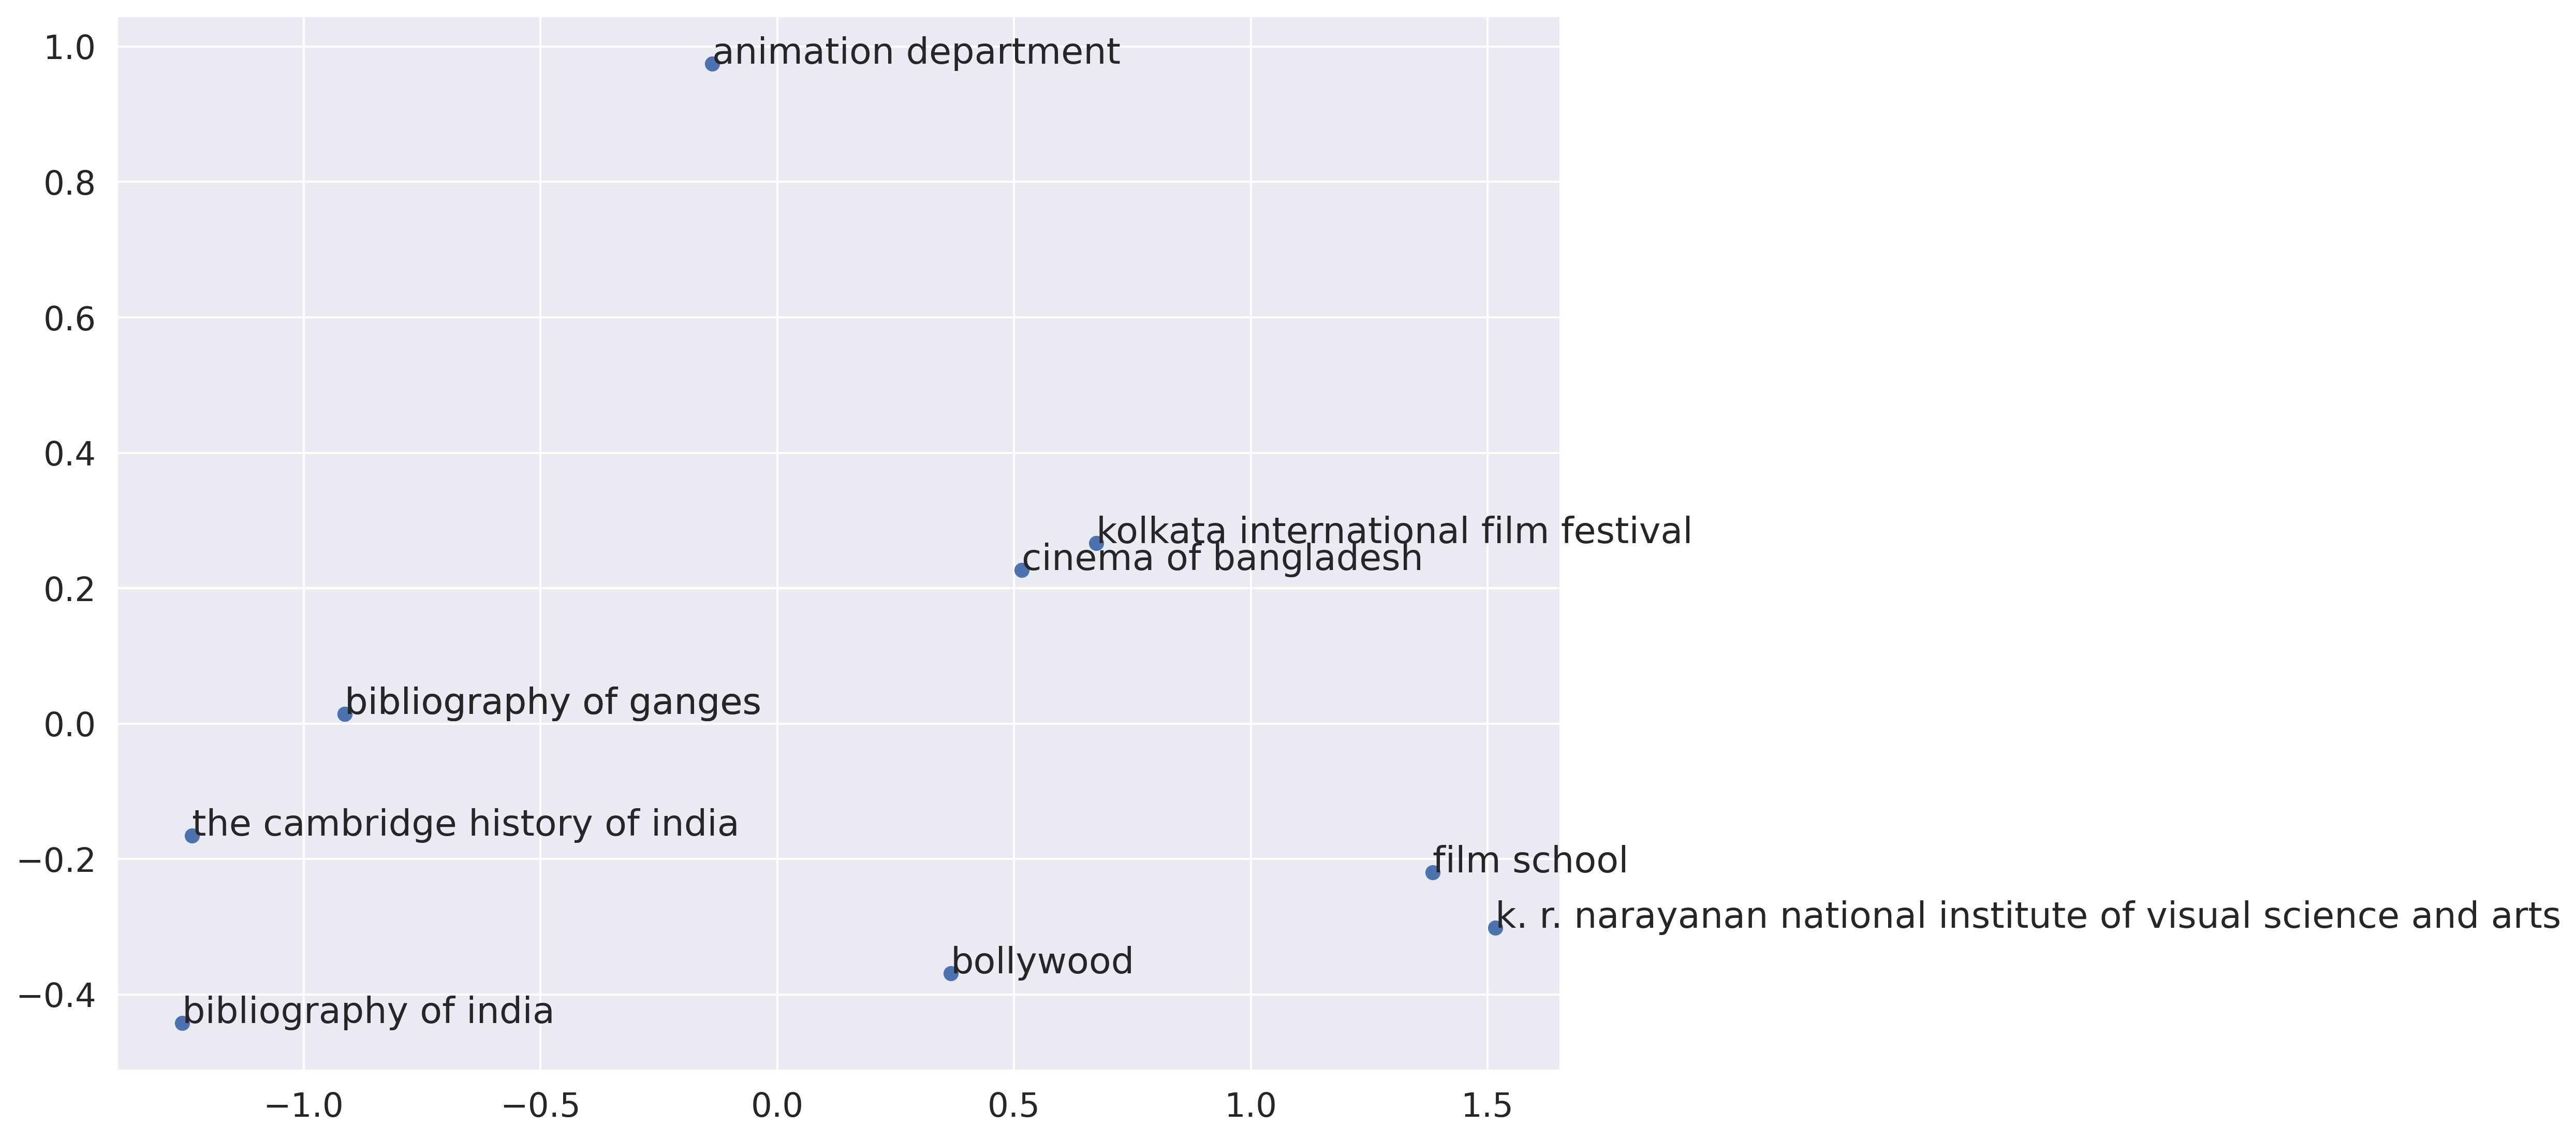

In [ ]:
plot_nodes(word_list)

### Skills

In [ ]:
!wget -O skills.xlsx https://github.com/jdmoore7/ONET_analysis/blob/master/Technology%20Skills.xlsx?raw=true

In [ ]:
skill_data = pd.read_excel('skills.xlsx')
skill_data.head()

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N
2,11-1011.00,Chief Executives,Atlassian JIRA,43232201,Content workflow software,Y
3,11-1011.00,Chief Executives,Blackbaud The Raiser's Edge,43232303,Customer relationship management CRM software,N
4,11-1011.00,Chief Executives,ComputerEase Construction Accounting,43231601,Accounting software,N


**Matrix factorization**

In [ ]:
x = pd.get_dummies(skill_data.set_index('Title')['Example'])

x = x.groupby(lambda var:var, axis=0).sum()

cols = x.columns.to_list()
rows = x.transpose().columns.to_list()

y = x.to_numpy()

job_skill_tensor = torch.FloatTensor(y)

In [ ]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_jobs=len(rows), n_skills=len(cols), n_factors=10):
        super().__init__()
        
        self.job_latent = nn.Parameter(torch.rand(n_jobs,n_factors))
        self.skill_latent = nn.Parameter(torch.rand(n_factors, n_skills))
        
        
    def forward(self):
        return torch.mm(self.job_latent,self.skill_latent)


model = MatrixFactorization()
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []
epochs = 1000
for epoch in range(epochs):
    loss = 0
    
    prediction = model.forward()
    loss += loss_fn(prediction, job_skill_tensor)
    losses.append(loss)

    # Reset the gradients to 0
    optimizer.zero_grad()

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()
    if epoch % 50 == 0:
        print(loss)

tensor(6.6961, grad_fn=<AddBackward0>)
tensor(0.2148, grad_fn=<AddBackward0>)
tensor(0.0772, grad_fn=<AddBackward0>)
tensor(0.0441, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0199, grad_fn=<AddBackward0>)
tensor(0.0146, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
tensor(0.0091, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)
tensor(0.0065, grad_fn=<AddBackward0>)
tensor(0.0057, grad_fn=<AddBackward0>)
tensor(0.0051, grad_fn=<AddBackward0>)
tensor(0.0047, grad_fn=<AddBackward0>)
tensor(0.0043, grad_fn=<AddBackward0>)
tensor(0.0041, grad_fn=<AddBackward0>)
tensor(0.0038, grad_fn=<AddBackward0>)
tensor(0.0037, grad_fn=<AddBackward0>)
tensor(0.0035, grad_fn=<AddBackward0>)
tensor(0.0034, grad_fn=<AddBackward0>)


In [ ]:
job_features = np.array(model.job_latent.detach())
skill_features = np.array(model.skill_latent.detach())
job_skill_stacked = np.concatenate((job_features,skill_features.transpose()))
job_skill_sim = cosine_similarity(job_skill_stacked)

entities = []
entities.extend(rows + cols)

def get_similar(node,sim_threshold=None,count_threshold=None,category=None):
  idx = entities.index(node)
  sim_scores = job_skill_sim[idx]
  retrieved = [(elem,score) for elem,score in zip(entities,sim_scores)]

  if category == 'jobs':
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx < len(rows)]
  elif category == 'skills':
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx > len(rows)]
  else:
    pass
  
  
  if sim_threshold:
    retrieved = [(elem,score) for elem,score in retrieved if score > sim_threshold]
  
  retrieved = sorted(retrieved,key=operator.itemgetter(1),reverse=True)

  if count_threshold:
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx < count_threshold]  
  
  return retrieved

get_similar('Python',category='jobs',sim_threshold=0.8,count_threshold=25)

[('Electrical Engineers', 0.8839187),
 ('Database Administrators', 0.87071097),
 ('Mapping Technicians', 0.86759377),
 ('Computer User Support Specialists', 0.867455),
 ('Software Quality Assurance Engineers and Testers', 0.8603918),
 ('Millwrights', 0.84810036),
 ('Information Technology Project Managers', 0.8404107),
 ('Computer Network Architects', 0.81890327),
 ('Customs Brokers', 0.81782794),
 ('Medical and Health Services Managers', 0.81116676)]

In [ ]:
# Save latent feature similarity values in a pickled file!

import pickle
with open('cos_sim_pickle.pkl', 'wb') as f:
  pickle.dump(job_skill_sim, f)

with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)  

with open('latent_features.pkl', 'wb') as f:
  pickle.dump(job_skill_stacked,f)   

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
p_comps = pca.fit_transform(job_skill_stacked)

from matplotlib.pyplot import xlim,ylim

plt.scatter(
    x=p_comps[:,0],y=p_comps[:,1],color=['r' if idx < len(rows) else 'b' for idx in range(job_skill_stacked.shape[0])],
    marker='+',
    alpha = 0.25,
)

**Deep walk**

In [ ]:
edges = skill_data[['Title','Example']].values.tolist()
net = nx.from_edgelist(edges)

In [ ]:
def random_walk(graph,seed,rounds=20):
  import random
  movements = [seed]
  for round in range(rounds):
    node_choices = [node for node in graph.neighbors(seed)]
    seed = random.choice(node_choices)
    movements.append(seed)
  return movements

random_walk(net,'Python')

['Python',
 'Multimedia Artists and Animators',
 'Autodesk Alias Surface',
 'Multimedia Artists and Animators',
 'Autodesk Mudbox',
 'Multimedia Artists and Animators',
 'Corel CorelDraw Graphics Suite',
 'Printing Press Operators',
 'Job scheduling software',
 'Printing Press Operators',
 'Job tracking software',
 'Printing Press Operators',
 'Inventory tracking software',
 'Laborers and Freight, Stock, and Material Movers, Hand',
 'Microsoft Publisher',
 'Human Resources Specialists',
 'Bond International Software Bond StaffSuite',
 'Human Resources Specialists',
 'YouTube',
 'Green Marketers',
 'WebTrends Analytics']

In [ ]:
walks = []
vertices = [n for n in net.nodes]
for v in vertices:
  walks.append(random_walk(graph=net,seed=v))

In [ ]:
embeddings = Word2Vec(walks,vector_size=10,window=5)
embeddings.save("graph2vec2.model")
embeddings.wv.most_similar('C++') ## verify results are sensible

[('Python', 0.9841578602790833),
 ('Oracle Java', 0.9794468879699707),
 ('Linux', 0.9633164405822754),
 ('Formula translation/translator FORTRAN', 0.9619031548500061),
 ('C', 0.9616402983665466),
 ('Practical extraction and reporting language Perl', 0.9614695310592651),
 ('Bioinformatics Scientists', 0.9572051763534546),
 ('UNIX', 0.9523270130157471),
 ('Agile Product Lifecyle Management PLM', 0.9469699263572693),
 ('Electronics Engineers, Except Computer', 0.9424154162406921)]

In [ ]:
net.nodes.items()

In [ ]:
    # X = []
    # for w in word_list:
    #   X.append()

embeddings.wv.get_vector('AdSense Tracker')

array([ 0.39639065,  0.02315119,  0.22326654,  0.04821965,  0.10308973,
        0.11157767,  0.10034148,  0.18131232, -0.20702969,  0.07792712],
      dtype=float32)

In [ ]:
from collections import defaultdict

array_dict = defaultdict()

for node in net.nodes:
  try:
    array_dict[node] = embeddings.wv.get_vector(node)
  except:
    pass

In [ ]:
embedded_nodes = [node for node in net.nodes if node in array_dict]
arrays = np.array([array_dict[node] for node in embedded_nodes])

skills = [skill for skill in skill_data['Example'].unique()]
jobs = [job for job in skill_data['Title'].unique()]
skill_idx = [idx for idx,elem in enumerate(embedded_nodes) if elem in skills]
job_idx = [idx for idx,elem in enumerate(embedded_nodes) if elem in jobs]

In [ ]:
pca = PCA(n_components=2)
p_comps = pca.fit_transform(arrays)

from matplotlib.pyplot import xlim,ylim

# xlim(-13,13)
# ylim(-13,13)
plt.scatter(
    # Jobs are red, skills are blue
    x=p_comps[:,0],y=p_comps[:,1],color=['b' if idx in skill_idx else 'r' for idx in range(len(arrays))],
    marker='+',
    alpha = 0.35,
    )

## Node2vec

### Basics

Node2Vec is very similar to DeepWalk, but the random walks are generated a bit differently. Recall that in the pure random walk, neighbourhood nodes have an equal propability to be chosen as next step. Here instead, we have 2 hyperparameters to tune - `p` and `q`. `p` and `q` control how fast the walk explores and leaves the neighborhood of starting node u.

* p - high values means that we're less likely to return to the previous node
* q - high values approximate the Breadth-First-Search meaning that the neighbourhood around the node is explored. Low values give higher chance to go outside the neighbourhood and hence approxiamtes the Depth-First-Search 

Let's compare 2 extreme scenarios:
1. p = 10, q = 0.1 - here we expect the random walk to go outwards and explore the adjacent clusters as well 
2. p = 0.1, q = 10 - here we expect the random walk to stay very local and explore the neighbourhood around the starting node

Here's the code block from `karate-club` package that does the Biased Random Walk. I'm showing it here so that you have a better understanding of what's happening under the hood.

In [ ]:
def biased_walk(start_node, walk_length, p, q):
    walk = [start_node]
    previous_node = None
    previous_node_neighbors = []
    for _ in range(walk_length-1):
        current_node = walk[-1]  # currnet node ID
        current_node_neighbors = np.array(list(graph.neighbors(current_node)))  # negihbours of this node
        probability = np.array([1/q] * len(current_node_neighbors), dtype=float)  # outwards probability weight determined by q
        probability[current_node_neighbors==previous_node] = 1/p  # probability of return determined by p
        probability[(np.isin(current_node_neighbors, previous_node_neighbors))] = 1  # weight of 1 to all the neighbours which are connected to the previous node as well
        norm_probability = probability/sum(probability)  # normalize the probablity
        selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]  # select the node from neighbours according to the probabilities from above
        walk.append(selected)  # append to the walk and continue
        previous_node_neighbors = current_node_neighbors
        previous_node = current_node
    
    return walk

In [ ]:
p = 10
q = 0.1
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

In [ ]:
p = 0.1
q = 10
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7)) 
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fafc3df5f-7d19-4710-92a0-67c5da83e51f%2FUntitled.png?table=block&id=74d4a809-249b-443c-acb8-2cc9af44d273&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

From the images we can see the differences between the resulting random walks. Each problem will have its own perfect `p` and `q` parameters so we can treat them as hyperparameters to tune. For now, let's just set the parameters to `p=0.5` and `q=0.25` but feel free to experiment with other parameters as well. Also, we're going to use the `karate-club` implementation of `BiasedRandomWalker` for the simplicity sake. Pleasd note that biased sampling takes longer to calculate, so grid searching the optimal hyperparameters is a long procedure.

### Node2vec Wiki

In [ ]:
G=nx.read_edgelist('../data/wiki/Wiki_edgelist.txt',
                      create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
model = Node2Vec(G, walk_length=10, num_walks=80,
                  p=0.25, q=4, workers=1, use_rejection_sampling=0)
model.train(window_size = 5, iter = 3)
embeddings=model.get_embeddings()

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


Learning embedding vectors...
Learning embedding vectors done!


In [ ]:
evaluate_embeddings(embeddings)

Training classifier using 80.00% nodes...
-------------------
{'micro': 0.659043659043659, 'macro': 0.5758708979465162, 'samples': 0.659043659043659, 'weighted': 0.6592287965622943, 'acc': 0.659043659043659}


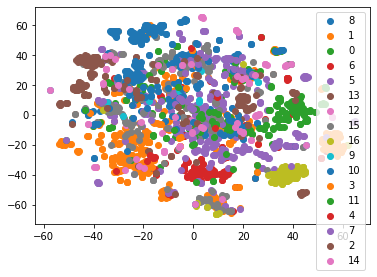

In [ ]:
plot_embeddings(embeddings)

### Facebook

In [ ]:
b_walker = BiasedRandomWalker(20, 10, 0.5, 0.25)
b_walker.do_walks(graph)

In [ ]:
node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 workers=4,
                 seed=42)

In [ ]:
# Get corresponding Node2Vec embeddings
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.933466844681798
[[9.57989497e-01 2.32558140e-02 3.00075019e-03 1.57539385e-02]
 [1.81290790e-02 9.53589558e-01 2.75562001e-02 7.25163162e-04]
 [6.22222222e-03 4.80000000e-02 9.44000000e-01 1.77777778e-03]
 [1.09589041e-01 2.13089802e-02 4.56621005e-02 8.23439878e-01]]


In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True)

In [ ]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 19/19 [04:16<00:00, 13.52s/it]


In [ ]:
sns.lineplot(x = np.arange(0.1, 2, 0.1), y = nv_micro_f1_scores, label='Node2Vec')
plt.xlabel('Labelled Proportion')
plt.plot()

In [ ]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)

ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)

As can be seen from the embeddings, the company, government, and tvshows are represented by clear clusters whereas politician clusters is kind of scattered around. Plus, there are pages which are not clustered meaning that they are probably much harder to classify.

## LINE Wiki

In [ ]:
G = nx.read_edgelist('../data/wiki/Wiki_edgelist.txt',
                      create_using=nx.DiGraph(), nodetype=None, data=[('weight', int)])

model = LINE(G, embedding_size=128, order='second')
model.train(batch_size=1024, epochs=50, verbose=2)
embeddings = model.get_embeddings()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
97/97 - 2s - loss: 0.6931
Epoch 2/50
97/97 - 1s - loss: 0.6915
Epoch 3/50
97/97 - 1s - loss: 0.6824
Epoch 4/50
97/97 - 1s - loss: 0.6310
Epoch 5/50
97/97 - 1s - loss: 0.5158
Epoch 6/50
97/97 - 1s - loss: 0.4233
Epoch 7/50
97/97 - 1s - loss: 0.3864
Epoch 8/50
97/97 - 1s - loss: 0.3471
Epoch 9/50
97/97 - 1s - loss: 0.3181
Epoch 10/50
97/97 - 1s - loss: 0.2938
Epoch 11/50
97/97 - 1s - loss: 0.2692
Epoch 12/50
97/97 - 1s - loss: 0.2481
Epoch 13/50
97/97 - 1s - loss: 0.2326
Epoch 14/50
97/97 - 1s - loss: 0.2083
Epoch 15/50
97/97 - 1s - loss: 0.1916
Epoch 16/50
97/97 - 1s - loss: 0.1766
Epoch 17/50
97/97 - 1s - loss: 0.1621
Epoch 18/50
97/97 - 1s - loss: 0.1516
Epoch 19/50
97/97 - 1s - loss: 0.1429
Epoch 20/50
97/

In [ ]:
evaluate_embeddings(embeddings)

Training classifier using 80.00% nodes...
-------------------
{'micro': 0.5883575883575883, 'macro': 0.445855222489147, 'samples': 0.5883575883575883, 'weighted': 0.5791532570580875, 'acc': 0.5883575883575883}


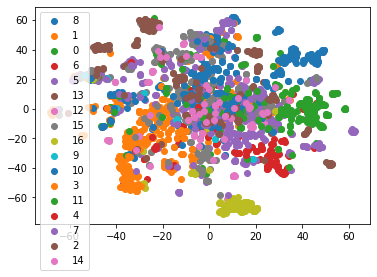

In [ ]:
plot_embeddings(embeddings)